### Simple input LIF model with F2F conversion

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Set device
# models_dir='/home/francesco/Developing/B2L/brian2lava-models-master/models'
# models_dir='/homes/jlubo/brian2lava-models/models'
# models_dir='/home/jlubo/brian2lava-models/models'
models_dir=None
#set_device('lava', mode='flexible', hardware='CPU', models_dir=models_dir) # use flexible-model mode (with CPU, floating-pt.)
#set_device('lava', mode='preset', hardware='Loihi2', models_dir=models_dir) # use preset-model mode with Loihi 2
#set_device('lava', mode='preset', hardware='CPU', num_repr='float', models_dir=models_dir) # use preset-model mode with CPU (floating-pt. representation)
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=True, models_dir=models_dir) # use preset-model mode with CPU (fixed-pt. representation)
# set_device('runtime')
# prefs.codegen.target = 'numpy'
BrianLogger.log_level_debug()

Preset models available:

lif_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_v_input -- CPU-only
atrlif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/atrlif -- CPU-only
probspiker -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/probspiker -- CPU-only
lif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif -- CPU-only
lif_rp_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_rp_v_input -- CPU-only

These models have been loaded and can be imported from 'brian2lava.preset_mode.model_loader' by their name. Given the currently available models, you might run, for example: 'from brian2lava.preset_mode.model_loader import lif_v_input'.


In [4]:
from brian2lava import ModelLoader
ModelLoader.available_preset_models()

Preset models available:

lif_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_v_input -- CPU-only
atrlif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/atrlif -- CPU-only
probspiker -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/probspiker -- CPU-only
lif -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif -- CPU-only
lif_rp_v_input -- /home/francesco/Developing/B2L/brian2lava/brian2lava/preset_mode/lib/model_lib/lif_rp_v_input -- CPU-only

These models have been loaded and can be imported from 'brian2lava.preset_mode.model_loader' by their name. Given the currently available models, you might run, for example: 'from brian2lava.preset_mode.model_loader import lif_v_input'.


In [5]:
# Import Loihi2 Lif models
from brian2lava.preset_mode.model_loader import lif

In [6]:
# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 0.5*ms

In [7]:
print(lif.equations, type(lif.equations))

dj/dt = -j/tau_j : V/s
dv/dt = -v/tau_v + j + bias : V (unless refractory) <class 'brian2.equations.equations.Equations'>


In [8]:
print(lif.conditions)

{'th': 'v > v_th', 'rs': 'v = v_rs'}


LaTeX equations                                                                 
--------------------------------------------------------------------------------


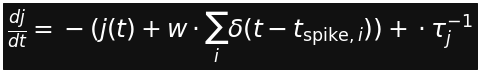

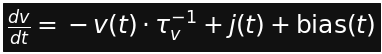

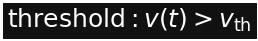

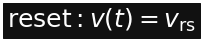



Raw LaTeX equations                                                             
--------------------------------------------------------------------------------
\frac{dj}{dt} = -(j(t) + w\cdot\sum_i \delta(t - t_{\mathrm{spike},i})) + \cdot \tau_j^{-1}
\frac{dv}{dt} = -v(t) \cdot \tau_v^{-1} + j(t) + \mathrm{bias}(t)               
\mathrm{threshold} : v(t) > v_\mathrm{th}                                       
\mathrm{reset} : v(t) = v_\mathrm{rs}                                           


Brian 2 ODEs                                                                    
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt (unless refractory)                          


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_

In [9]:
lif.show()

In [10]:
# Define parameters
N = 3
bias = 4*mV/ms #0*mV/ms
tau_j = 15*ms
tau_v = 10*ms
v_th = 50*mV
v_rs = -5*mV
ref = 0

# Add a spike generator group
S = SpikeGeneratorGroup(4, [0,1,2,0,2], [5,10,15,20,20]*ms)

# Add a neuron group (which receives a background input)
P = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='ref*ms', method='euler')
P.j = "5*mV/ms"
P.v = "45*mV"

# Add another neuron group (which does not receive a background input)
Q = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='ref*ms', method='euler')
#Q.j = "0.1*mV/ms"
Q.v = "2*mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0,1,2], j=[1])
syn.w = 5 * mV/ms

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [11]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [12]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
spmP = SpikeMonitor(P, variables='v', record=True)
spmQ = SpikeMonitor(Q, variables='v', record=range(2))

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)

DEBUG      Monitor _spike_spikemonitor_v not added yet, will add the additional var monitor for v later. [brian2.devices.lava]
WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compared to Brian 2, 
        where the 'record' parameter only accepts boolean values). Otherwise, all elements are monitored regardless of the 
        specified indices, and filtering is done only as a post-processing step - thus, no performance gain will come from it. [brian2.devices.lava]
DEBUG      Monitor _spike_spikemonitor_1_v not added yet, will add the additional var monitor for v later. [brian2.devices.lava]
WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compare

In [13]:
# Run simulation
run(30*ms)

DEBUG      Updated MagicNetwork to include 17 objects with names statemonitor, statemonitor_1, statemonitor_2, neurongroup_1, neurongroup_stateupdater, synapses, neurongroup_1_spike_thresholder, statemonitor_3, neurongroup_1_spike_resetter, neurongroup_spike_thresholder, neurongroup_spike_resetter, synapses_pre, neurongroup, spikemonitor, spikemonitor_1, neurongroup_1_stateupdater, spikegeneratorgroup [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 17 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.03s) [brian2.stateupdaters.base.method_choice]

Selected preset model 'LIF'
Selected preset model 'LIF'
Found scaling parameters for neurongroup: {'alpha_t': 2000.0, 'A': 167772120.0}
Found scaling parameters for neurongroup_1: {'alpha_t': 2000.0, 'A': 13106800.0}
Shifted v_th, 131071, 6
Shifted v_rs, -13107, 6
Shifted v_th, 10239, 6
Shifted v_rs, -1023, 6
SCALED WEIGHTS [[    0.     0.     0.     0.]
 [32767. 32767. 32767.     0.]
 [    0.     0.     0.     0.]]
Shifted weights, [[  0   0   0   0]
 [511 511 511   0]
 [  0   0   0   0]], 6
Running Lava simulation for 30. ms (60 steps)


DEBUG      Process 'neurongroup_1' initialized with PyLifModelBitAcc process model [brian2.devices.lava]
DEBUG      Running process: neurongroup, <class 'lava_workspace.CPU_preset_neurongroup.LIF'> [brian2.devices.lava]
DEBUG      Process 'neurongroup' initialized with PyLifModelBitAcc process model [brian2.devices.lava]
DEBUG      Successfully run simulation [brian2.devices.lava]
DEBUG      Retrieving monitor values [brian2.devices.lava]
DEBUG      Successfully retrieved monitor values [brian2.devices.lava]
DEBUG      Updating Brian variables [brian2.devices.lava]
DEBUG      Successfully updated Brian variables! [brian2.devices.lava]


Retrieving monitor values
Updating Brian variables


In [14]:
#stm2.variables['v'].get_value()
print(f"P.v = {P.v}")
print(f"P.j = {P.j}")
print(f"Q.v = {Q.v}")
print(f"Q.j = {Q.j}")
print(f"stmPv.t =\n{stmPv.t}")
print(f"stmPv.v =\n{stmPv.v}")
print(f"stmPj.j =\n{stmPj.j}")
print(f"stmQv.v =\n{stmQv.v}")
print(f"stmQj.j =\n{stmQj.j}")

P.v = <neurongroup.v: array([34.1445289, 34.1445289, 34.1445289]) * mvolt>
P.j = <neurongroup.j: array([0.64922587, 0.64922587, 0.64922587]) * volt / second>
Q.v = <neurongroup_1.v: array([38.20856349,  1.9042024 , 38.20856349]) * mvolt>
Q.j = <neurongroup_1.j: array([0.       , 9.2997528, 0.       ]) * volt / second>
stmPv.t =
<statemonitor.t: array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5]) * msecond>
stmPv.v =
[[44.99999762 47.16384343 49.13856367 -4.9999249  -0.568092    3.56895413
   7.42839752 11.02649832 14.37861666 17.49926627 20.40216813 23.10027435
  25.60582175 27.93037961 30.08486154 32.07957317 33.92425392 35.62808886
  37.19

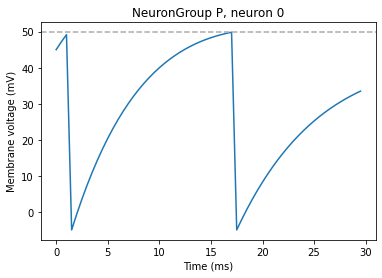

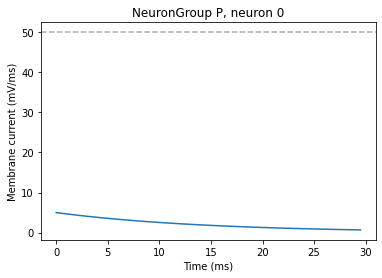

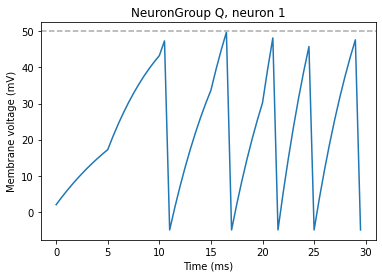

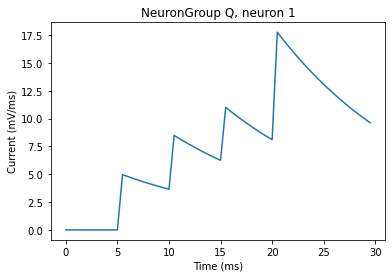

In [15]:
plt.plot(stmPv.t/ms,stmPv.v[0]/mV)
plt.axhline(v_th/mV, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (ms)')
ylabel('Membrane voltage (mV)')
show()

plt.plot(stmPj.t/ms,stmPj.j[0]/mV*ms)
plt.axhline(v_th/mV, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (ms)')
ylabel('Membrane current (mV/ms)')
show()

plt.plot(stmQv.t/ms,stmQv.v[1]/mV)
plt.axhline(v_th/mV, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 1')
xlabel('Time (ms)')
ylabel('Membrane voltage (mV)')
show()
plt.plot(stmQv.t/ms,stmQj.j[1]/mV*ms)
title('NeuronGroup Q, neuron 1')
xlabel('Time (ms)')
ylabel('Current (mV/ms)')
show()

In [16]:
print(spmP.i)
print(spmP.t/second)
print(spmQ.i)
print(spmQ.t/second)
print(f"NeuronGroup P: {len(spmP.i)} spikes occurred in total.")
print(f"NeuronGroup Q: {len(spmQ.i)} spikes occurred in total.")

<spikemonitor.i: array([0, 1, 2, 0, 1, 2])>
[0.001 0.001 0.001 0.017 0.017 0.017]
<spikemonitor_1.i: array([1, 1, 1, 1, 1])>
[0.0105 0.0165 0.021  0.0245 0.029 ]
NeuronGroup P: 6 spikes occurred in total.
NeuronGroup Q: 5 spikes occurred in total.
